In [1]:
# Stock Purchase Decision based on Moving Average Close Price


# MA 5 days - for hyper trading, extreme fast signal
# MA 10 days, MA 20 days - for swing trading, fast signal, recent change in stock price
# MA 50 days - for medium-term position trading, medium fast signal, 
# MA 200 days - for long-term portfolio trading, slow signal, long term history


In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.8 MB/s 
     |████████████████████████████████| 112 kB 18.6 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 110 kB 56.4 MB/s 
     |████████████████████████████████| 4.0 MB 57.5 MB/s 
     |████████████████████████████████| 128 kB 47.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
import numpy as np
from scipy.stats import ttest_ind
import datetime
%matplotlib inline

In [4]:
 # 1. Choose the best MA for Short Term 5 days investment

 # Find the best moving average according to the investment period we choose
 # Use faster MA for shorter investment periods, use higher/slower MA for longer investment periods

In [5]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('font', size=14)

In [ ]:
# Short Term Investment, META Ticker name, calculate return after 5 days open window
# We want to keep the Facebook stock in portfolio only for 5 days, hypertrading example
# Calculate the average return value after 5 days when the close price is over the moving average (we don’t consider short positions for this example)

In [6]:
n_forward = 5 # keep stock only 5 days
name = 'META' # META is a Facebook Ticker name
start_date = "2010-01-01"
end_date = "2022-12-01"

In [7]:
ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date) # Consider daily data
data['Forward Close'] = data['Close'].shift(-n_forward) # Close 5 days ago
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close'] # 5 days difference in close price 

In [ ]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Forward Close,Forward Return
Date,,,,,,,,,
2012-05-18 00:00:00-04:00,42.049999,45.000000,38.000000,38.230000,573576400,0,0,31.910000,-0.165315
2012-05-21 00:00:00-04:00,36.529999,36.660000,33.000000,34.029999,168192700,0,0,28.840000,-0.152512
2012-05-22 00:00:00-04:00,32.610001,33.590000,30.940001,31.000000,101786600,0,0,28.190001,-0.090645
2012-05-23 00:00:00-04:00,31.370001,32.500000,31.360001,32.000000,73600000,0,0,29.600000,-0.075000
2012-05-24 00:00:00-04:00,32.950001,33.209999,31.770000,33.029999,50237200,0,0,27.719999,-0.160763


In [8]:
# Find the most suitable MA, that maximizes the expected return on investment for short term trader.
# If we buy at 100 USD and after the chosen period the price rises to 105 USD, we have a 5 USD return in 5 days.

result = []
train_size = 0.6 # Split data to train 60% and test 40%
for sma_length in range(20, 500):  # Define the range the desired number of periods should be
  
  data['SMA'] = data['Close'].rolling(sma_length).mean() 
  data['input'] = [int(x) for x in data['Close'] > data['SMA']]
  
  df = data.dropna()
  training = df.head(int(train_size * df.shape[0]))
  test = df.tail(int((1 - train_size) * df.shape[0]))
  
  tr_returns = training[training['input'] == 1]['Forward Return']
  test_returns = test[test['input'] == 1]['Forward Return']

  mean_forward_return_training = tr_returns.mean()
  mean_forward_return_test = test_returns.mean()

  pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]
 
  result.append({
      'sma_length':sma_length, # recommended number of periods in given range 
      'training_forward_return': mean_forward_return_training,
      'test_forward_return': mean_forward_return_test,
      'p-value':pvalue
  })

In [9]:
result.sort(key = lambda x : -x['training_forward_return'])

In [10]:
# ideal MA for 5 days open window is 292
# p-value is higher than 5%,average return in the test set is comparable with the average return in the training set
# no overfitting

result[0]

{'sma_length': 292,
 'training_forward_return': 0.007846398289288256,
 'test_forward_return': 0.0023865605432836536,
 'p-value': 0.011651467554340753}

In [11]:
best_sma = result[0]['sma_length']
data['SMA'] = data['Close'].rolling(best_sma).mean()

In [12]:
best_sma

292

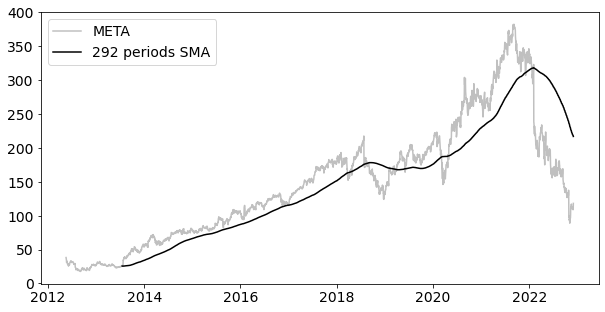

In [13]:
plt.plot(data['Close'],label=name, color='silver')
plt.plot(data['SMA'],label = "{} periods SMA".format(best_sma),color='black')
plt.legend()
plt.show()

In [14]:
data.to_csv('MA292.csv', index=False)

In [ ]:
# 2. Choose the best MA for Mid Term 50 days investment
# Mid Term Investment, GLD Ticker name, calculate return after 50 days open window, analyse 10 years data 
# We want to keep the stock in portfolio for 50 days, mid term position trading example

In [16]:
n_forward = 50
name = 'META'
start_date = "2010-01-01"
end_date = "2022-12-01"

In [17]:
ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date)
data['Forward Close'] = data['Close'].shift(-n_forward)
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']

In [18]:
# Find the most suitable MA, that maximizes the expected return on investment for medium position trader.
# If we buy at 100 USD and after the chosen period the price rises to 105 USD, we have a 5 USD return in 50 days

result = []
train_size = 0.6
for sma_length in range(20,500):
  
  data['SMA'] = data['Close'].rolling(sma_length).mean()
  data['input'] = [int(x) for x in data['Close'] > data['SMA']]
  
  df = data.dropna()
  training = df.head(int(train_size * df.shape[0]))
  test = df.tail(int((1 - train_size) * df.shape[0]))
  
  tr_returns = training[training['input'] == 1]['Forward Return']
  test_returns = test[test['input'] == 1]['Forward Return']
  mean_forward_return_training = tr_returns.mean()
  mean_forward_return_test = test_returns.mean()
  pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]
 
  result.append({
      'sma_length':sma_length,
      'training_forward_return': mean_forward_return_training,
      'test_forward_return': mean_forward_return_test,
      'p-value':pvalue
  })

In [19]:
result.sort(key = lambda x : -x['training_forward_return'])

In [20]:
# ideal MA for 50 days open window is 233
# p-value is higher than 5%, average return in the test set is comparable with the average return in the training set
# no overfitting

result[0]

{'sma_length': 233,
 'training_forward_return': 0.06732649394744668,
 'test_forward_return': 0.014153312966909656,
 'p-value': 1.1918593084024051e-15}

In [21]:
best_sma = result[0]['sma_length']
data['SMA'] = data['Close'].rolling(best_sma).mean()

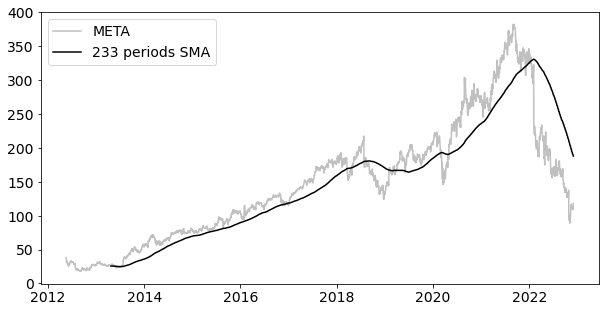

In [22]:
plt.plot(data['Close'],label=name, color='silver')
plt.plot(data['SMA'],label = "{} periods SMA".format(best_sma),color='black')
plt.legend()
plt.show()

In [23]:
data.to_csv('MA233.csv', index=False)

In [24]:
# 3. Calculate Crossover example: MA10 Close over MA50 Close

# load the facebook data, Ticker for facebook has changed from FB to Meta 
name = 'META'
start_date = "2010-01-01"
end_date = "2022-12-01"
ticker = yfinance.Ticker(name)
fb = ticker.history(interval="1d",start=start_date,end=end_date)

In [25]:
# we have 2652 rows in data file
fb.shape

(2652, 7)

In [26]:
fb.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18 00:00:00-04:00,42.049999,45.000000,38.000000,38.230000,573576400,0.0,0.0
2012-05-21 00:00:00-04:00,36.529999,36.660000,33.000000,34.029999,168192700,0.0,0.0
2012-05-22 00:00:00-04:00,32.610001,33.590000,30.940001,31.000000,101786600,0.0,0.0
2012-05-23 00:00:00-04:00,31.370001,32.500000,31.360001,32.000000,73600000,0.0,0.0
2012-05-24 00:00:00-04:00,32.950001,33.209999,31.770000,33.029999,50237200,0.0,0.0


In [27]:
fb.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-11-23 00:00:00-05:00,111.720001,112.669998,110.730003,112.239998,21343100,0.0,0.0
2022-11-25 00:00:00-05:00,111.300003,112.730003,111.019997,111.410004,12007600,0.0,0.0
2022-11-28 00:00:00-05:00,110.779999,112.040001,108.379997,108.779999,23309400,0.0,0.0
2022-11-29 00:00:00-05:00,109.540001,110.940002,108.540001,109.459999,23899200,0.0,0.0
2022-11-30 00:00:00-05:00,109.510002,118.160004,109.379997,118.099998,43348600,0.0,0.0


In [28]:
# Add columns: MA10 (moving average for 10 days), MA50 (moving average for 50 days), MA200, MA233, MA292, ...
# Use dropna to remove not numerical data.

fb['MA5 hyper'] = fb['Close'].rolling(5).mean() # hyper fast signal
fb['MA10 fast'] = fb['Close'].rolling(10).mean() # fast signal
fb['MA50 medium'] = fb['Close'].rolling(50).mean() # medium signal
fb['MA200 long'] = fb['Close'].rolling(200).mean() # slow signal
fb['MA233 long'] = fb['Close'].rolling(233).mean() # slow signal
fb['MA292 long'] = fb['Close'].rolling(292).mean() # slow signal

fb = fb.dropna()

fb.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long
Date,,,,,,,,,,,,,
2013-07-18 00:00:00-04:00,26.75,26.770000,26.120001,26.180000,24806900,0.0,0.0,26.268000,25.751,24.9222,25.7767,24.978154,25.690959
2013-07-19 00:00:00-04:00,25.82,26.110001,25.600000,25.879999,46539700,0.0,0.0,26.262000,25.902,24.8974,25.7978,24.996524,25.648664
2013-07-22 00:00:00-04:00,25.99,26.129999,25.719999,26.049999,27526300,0.0,0.0,26.216000,26.036,24.8776,25.8181,25.020858,25.621336
2013-07-23 00:00:00-04:00,26.10,26.299999,25.969999,26.129999,28221600,0.0,0.0,26.177999,26.101,24.8666,25.8374,25.042017,25.604657
2013-07-24 00:00:00-04:00,26.32,26.530001,26.049999,26.510000,82635600,0.0,0.0,26.150000,26.172,24.8604,25.8608,25.070515,25.585856


In [29]:
# Golden Cross - If MA10 fast is larger than MA50 slow, the stock price goes up in the next several days and we will buy and hold one share of stock.
# Dead Cross - If MA10 fast is smaller than MA50 slow, the price will probably decrease. 

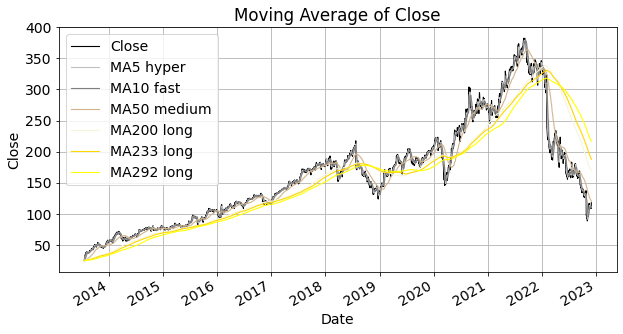

In [30]:
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2022-12-01')                                                

# plot moving averages to see the smooth trendlines, see the multiple crossovers

kwargs= dict (linestyle='solid', color=['black','silver', 'grey','tan', 'beige', 'gold','yellow',], linewidth=1.1)
line_plot = fb.plot( y = ['Close','MA5 hyper', 'MA10 fast','MA50 medium', 'MA200 long','MA233 long', 'MA292 long'], figsize= (10,5),**kwargs ) 
line_plot.set_title('Moving Average of Close')
line_plot.grid()
line_plot.set_xlabel('Date')
line_plot.set_ylabel('Close');

1, Golden cross - MA10 fast > MA50 medium, Buy signal, purchase stock this day.
0, Dead cross - MA10 fast < MA50 medium, Sell signal, do not purchase stock this day.


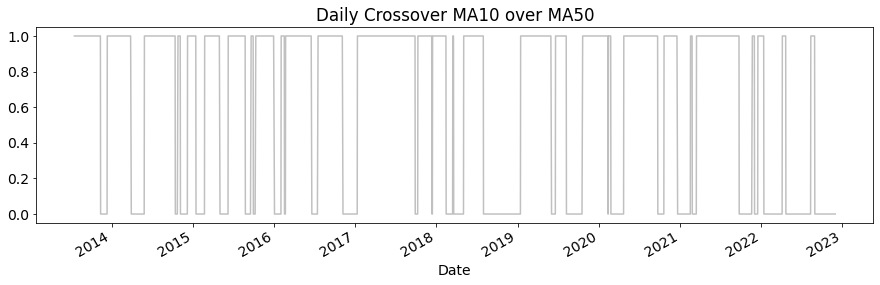

In [31]:
# Add a new column "Crossover", if MA10 fast > MA50 medium, denote as 1 (fast signal to buy stock), otherwise, denote as 0 (do nothing)
# 1 - Golden Cross, fast signal to hold and buy stock, 0 - Dead Cross, fast signal to do nothing

fb['Crossover'] = [1 if fb.loc[ei, 'MA10 fast']>fb.loc[ei, 'MA50 medium'] else 0 for ei in fb.index]

start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2022-12-01')   

fb['Crossover'].plot(color='silver', figsize= (15,4))
plt.title('Daily Crossover MA10 over MA50')

print('1, Golden cross - MA10 fast > MA50 medium, Buy signal, purchase stock this day.') # Yes
print('0, Dead cross - MA10 fast < MA50 medium, Sell signal, do not purchase stock this day.') # No

In [32]:
fb.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long,Crossover
Date,,,,,,,,,,,,,,
2013-07-18 00:00:00-04:00,26.75,26.770000,26.120001,26.180000,24806900,0.0,0.0,26.268000,25.751,24.9222,25.7767,24.978154,25.690959,1
2013-07-19 00:00:00-04:00,25.82,26.110001,25.600000,25.879999,46539700,0.0,0.0,26.262000,25.902,24.8974,25.7978,24.996524,25.648664,1
2013-07-22 00:00:00-04:00,25.99,26.129999,25.719999,26.049999,27526300,0.0,0.0,26.216000,26.036,24.8776,25.8181,25.020858,25.621336,1
2013-07-23 00:00:00-04:00,26.10,26.299999,25.969999,26.129999,28221600,0.0,0.0,26.177999,26.101,24.8666,25.8374,25.042017,25.604657,1
2013-07-24 00:00:00-04:00,26.32,26.530001,26.049999,26.510000,82635600,0.0,0.0,26.150000,26.172,24.8604,25.8608,25.070515,25.585856,1


If Profit is positive, we should buy stock and we can earn the money.
If Profit is negative, we should not buy stock, not to lose the money.


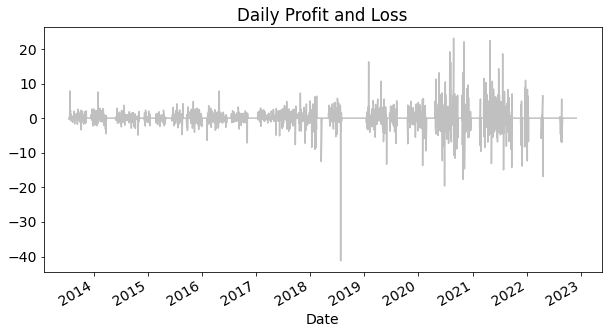

In [33]:
# Add a new column "Profit" using List Comprehension, for any rows in fb, if Crossover=1
# Daily Profit = the close price of Tomorrow - the close price of Today. Otherwise the profit is 0.

fb['Close1'] = fb['Close'].shift(-1)

# Positive Profit are days above - We woud have earn the money, if we would purchase the stock.
# Negative Profit are days below - We would lose the money, if we would purchase the stock.

fb['Profit'] = [fb.loc[ei, 'Close1'] - fb.loc[ei, 'Close'] if fb.loc[ei, 'Crossover']==1 else 0 for ei in fb.index]

start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2022-12-01')   

# Plot a graph to show the Profit and Loss

fb['Profit'].plot(color='silver')
plt.title('Daily Profit and Loss')

print('If Profit is positive, we should buy stock and we can earn the money.')
print('If Profit is negative, we should not buy stock, not to lose the money.')

In [34]:
# Use .cumsum() to calculate the accumulated wealth over the period
# Create new variable cumultive wealth
# Example strategy MA10 over MA50 is making in day 2022-11-23 USD 95.95, Wealth

fb['Wealth'] = fb['Profit'].cumsum()
fb.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long,Crossover,Close1,Profit,Wealth
Date,,,,,,,,,,,,,,,,,
2022-11-23 00:00:00-05:00,111.720001,112.669998,110.730003,112.239998,21343100,0.0,0.0,111.408000,112.646001,123.451199,171.76010,191.776138,219.961679,0,111.410004,0.0,95.950016
2022-11-25 00:00:00-05:00,111.300003,112.730003,111.019997,111.410004,12007600,0.0,0.0,111.400002,112.600001,122.688400,171.15715,190.836052,219.180172,0,108.779999,0.0,95.950016
2022-11-28 00:00:00-05:00,110.779999,112.040001,108.379997,108.779999,23309400,0.0,0.0,110.746001,112.176001,121.938200,170.56070,189.864121,218.390411,0,109.459999,0.0,95.950016
2022-11-29 00:00:00-05:00,109.540001,110.940002,108.540001,109.459999,23899200,0.0,0.0,110.666000,111.700001,121.167000,170.01025,188.848155,217.590583,0,118.099998,0.0,95.950016
2022-11-30 00:00:00-05:00,109.510002,118.160004,109.379997,118.099998,43348600,0.0,0.0,111.998000,111.802000,120.607200,169.51225,187.869099,216.877809,0,NaN,0.0,95.950016


In [35]:
fb.tail(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long,Crossover,Close1,Profit,Wealth
Date,,,,,,,,,,,,,,,,,
2022-11-28 00:00:00-05:00,110.779999,112.040001,108.379997,108.779999,23309400,0.0,0.0,110.746001,112.176001,121.9382,170.56070,189.864121,218.390411,0,109.459999,0.0,95.950016
2022-11-29 00:00:00-05:00,109.540001,110.940002,108.540001,109.459999,23899200,0.0,0.0,110.666000,111.700001,121.1670,170.01025,188.848155,217.590583,0,118.099998,0.0,95.950016
2022-11-30 00:00:00-05:00,109.510002,118.160004,109.379997,118.099998,43348600,0.0,0.0,111.998000,111.802000,120.6072,169.51225,187.869099,216.877809,0,NaN,0.0,95.950016


Total money you win is 95.95001602172852
Total money you spent is 26.18000030517578


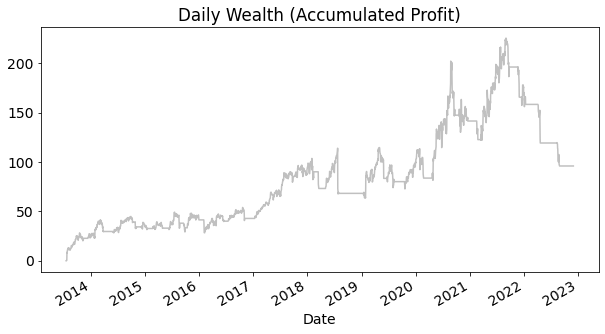

In [36]:
# Plot the wealth to show the growth of profit over the period

start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2022-12-01')                                                   


fb['Wealth'].plot(color='silver')
plt.title('Daily Wealth (Accumulated Profit)')

print('Total money you win is {}'.format(fb.loc[fb.index[-2], 'Wealth'])) # wealth at the end of considered time period
print('Total money you spent is {}'.format(fb.loc[fb.index[0], 'Close'])) # initial investment is the stock price on the first day, Close

In [37]:
fb.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long,Crossover,Close1,Profit,Wealth
Date,,,,,,,,,,,,,,,,,
2013-07-18 00:00:00-04:00,26.75,26.770000,26.120001,26.180000,24806900,0.0,0.0,26.268000,25.751,24.9222,25.7767,24.978154,25.690959,1,25.879999,-0.300001,-0.300001
2013-07-19 00:00:00-04:00,25.82,26.110001,25.600000,25.879999,46539700,0.0,0.0,26.262000,25.902,24.8974,25.7978,24.996524,25.648664,1,26.049999,0.170000,-0.130001
2013-07-22 00:00:00-04:00,25.99,26.129999,25.719999,26.049999,27526300,0.0,0.0,26.216000,26.036,24.8776,25.8181,25.020858,25.621336,1,26.129999,0.080000,-0.050001
2013-07-23 00:00:00-04:00,26.10,26.299999,25.969999,26.129999,28221600,0.0,0.0,26.177999,26.101,24.8666,25.8374,25.042017,25.604657,1,26.510000,0.380001,0.330000
2013-07-24 00:00:00-04:00,26.32,26.530001,26.049999,26.510000,82635600,0.0,0.0,26.150000,26.172,24.8604,25.8608,25.070515,25.585856,1,34.360001,7.850000,8.180000


In [38]:
fb = fb.drop('Stock Splits', axis=1)

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


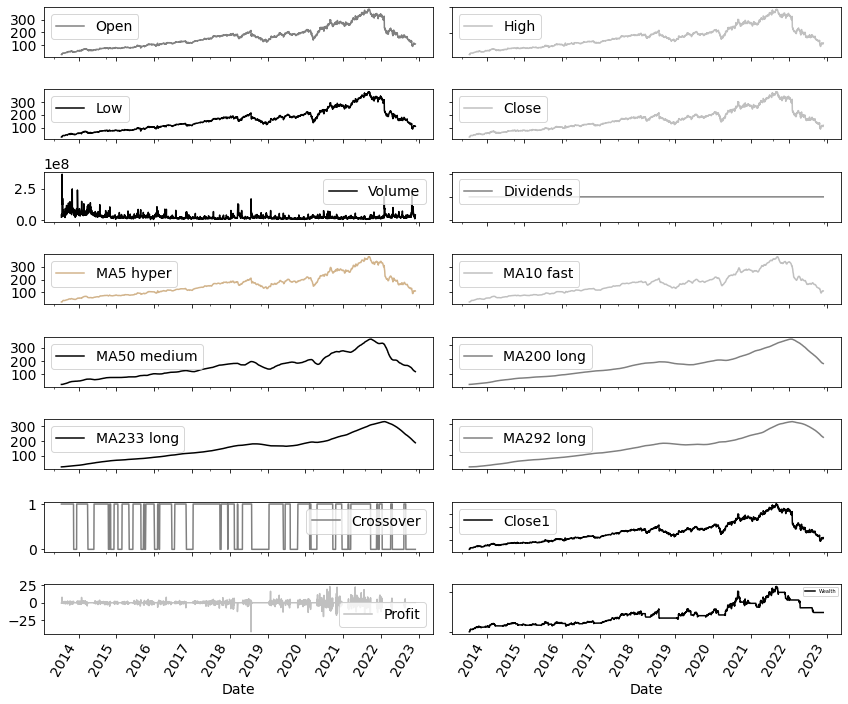

In [39]:
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2022-12-01')   

fig, a = plt.subplots(8, 2, figsize=(12, 10), tight_layout=True)
fb.plot(ax=a,subplots = True, figsize = (10, 10), rot=60,sharex=True, sharey=True,
                color={"Open": "grey", "High": "silver","Low": "black", "Close": "silver",
                       "Volume": "black","Dividends": "grey", "MA5 hyper": "tan","MA10 fast": "silver", 
                       "MA50 medium": "black","MA200 long": "grey","MA233 long": "black","MA292 long": "grey",
                       "Crossover": "grey", "Close1": "black", "Profit": "silver", "Wealth": "black"});
plt.legend(loc = 'best', fontsize=5)
plt.show()

In [40]:
fb.to_csv('FB_MA.csv', index=False)